In [ ]:
# Notes
# The file is executed in Google Colab environment.
# The CSV and shape files were uploaded in content folder.
# The images were also generated in content folder.
# Then, the images were downloaded and stored.
# We have renamed column names of coordinates 
# location.coordinates.0 to x and
# location.coordinates.1 to y and used the file for assignment.

In [0]:
# Making environment ready
import os
def install_req():
  !apt-get install -qq curl g++ make
  !curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
  os.chdir('spatialindex-src-1.8.5')
  !./configure
  !make
  !make install
  
  os.chdir('..')
  !pip install geopandas shapely descartes rtree

In [2]:
# Making environment ready
!pip uninstall geopandas rtree
install_req()

Uninstalling geopandas-0.5.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/geopandas-0.5.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/geopandas/*
Proceed (y/n)? y
  Successfully uninstalled geopandas-0.5.1
Uninstalling Rtree-0.8.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Rtree-0.8.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/rtree/*
Proceed (y/n)? y
  Successfully uninstalled Rtree-0.8.3
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0   488k      0  0:00:01  0:00:01 --:--:--  488k
checking build system type... x86_64-unknown-linux-gnu
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
che

In [0]:
# Making environment ready
!ldconfig

In [4]:
# Making environment ready
from rtree import index
from rtree.index import Rtree
p = index.Property()
idx = index.Index(properties=p)
idx

In [5]:
# Making environment ready
!pip install geopandas
!pip install mapclassify

In [0]:
# importing libraries
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
import shapely
import missingno as msn
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN

% matplotlib inline

# Question 1

In [0]:
# Import AISData which contains vessels data
# We have renamed coordinate column names in csv files 
# location.coordinates.0 to x
# location.coordinates.1 to y. The updated file(only column names updated)
# was used for assigment.
df_AISData=pd.read_csv('AISData.csv')
gdf_AISData = gpd.GeoDataFrame(df_AISData.drop(['x', 'y'], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[shapely.geometry.Point(xy) for xy in zip(df_AISData.x, df_AISData.y)])  # to get exact location of vesells

In [8]:
# Lets' check Vessels data
df_AISData.head()

,Unnamed: 0,event_time,x,y,position_accuracy,mmsi,sog,cog
0,0,2019-04-11T09:47:30.153Z,-63.556082,44.624835,0.0,316013808,3.0,319.500000
1,1,2019-04-11T09:47:27.273Z,-63.556053,44.624817,0.0,316013808,3.0,320.700012
2,2,2019-04-11T09:47:34.340Z,-63.556138,44.624868,0.0,316013808,2.9,319.500000
3,3,2019-04-11T09:47:37.087Z,-63.556187,44.624898,0.0,316013808,3.0,319.799988
4,4,2019-04-19T09:52:19.358Z,-63.555998,44.624883,0.0,316013808,3.2,337.200012


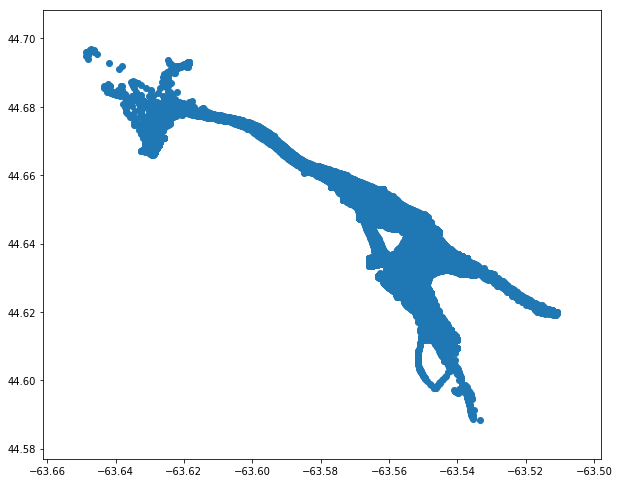

In [9]:
# let's plot the vessels data now
gdf_AISData.plot(figsize=(10,10))   # contains all location of ferries

In [0]:
# Import ports data
# Here, we are keeping buffer as 1 km. if we increase buffer,
# there are high chances that more buffers will intersect for
# different ports.
# https://gis.stackexchange.com/a/253387
df_ports = gpd.read_file("assignment3shapefile.shp")
gdf_ports = df_ports.geometry.buffer(0.001)

In [11]:
# Let's print port data now
df_ports.head()

,field_1,port_name,size,geometry
0,0,pointpolygon,0.0000,"POLYGON ((-63.59160304069519 44.6649292254607,..."
1,1,port1,0.0018,"POLYGON ((-63.569431 44.649993, -63.5694396674..."
2,2,port2,0.0018,"POLYGON ((-63.60949000000001 44.675853, -63.60..."
3,3,ind,0.0000,POLYGON ((-63.54742169380188 44.64697911403847...
4,4,port5,0.0018,"POLYGON ((-63.568048 44.663875, -63.5680566674..."


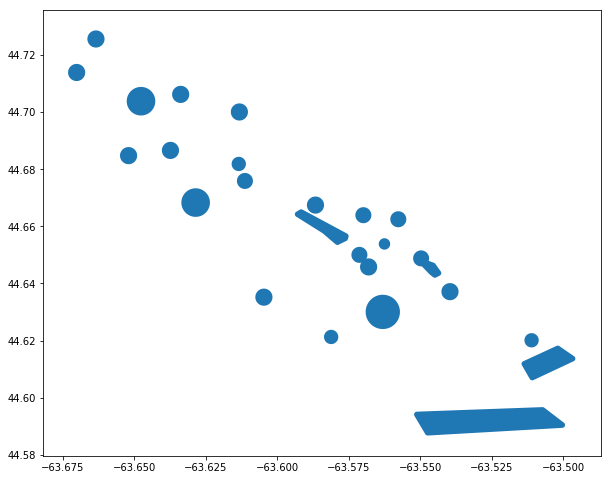

In [12]:
# Plotting ports data
gdf_ports.plot(figsize=(10,10))

In [13]:
# Now, let's check which message intersects with which port.
# Below function will create an dataframe which maps
# message against intersection with the port name.
# Last column namely combine will have a list of all values from 
# other columns. This column is created just to add to AISData to keep
# track of message intersection using a list.
# https://stackoverflow.com/a/43898233/8243992
# https://stackoverflow.com/a/26098292/8243992
# https://stackoverflow.com/a/20603020/8243992
def checkPortVisit(dataFrame):
  newDataFrame = pd.DataFrame({df_ports['port_name'][0]: dataFrame.within(gdf_ports[0])})  
  for i in range(1, len(gdf_ports)):
    # Using within, the intersects are found and the series is converted to dataframe
    newDataFrame = newDataFrame.join(pd.DataFrame({df_ports['port_name'][i]: gdf_AISData.within(gdf_ports[i])}))
  newDataFrame['combine'] = newDataFrame.values.tolist()
  return newDataFrame

gdf_AISData_portVisit = checkPortVisit(gdf_AISData)
gdf_AISData_portVisit.head()

,pointpolygon,port1,port2,ind,port5,port6,port7,south_enterance,auto_port,southend container terminal,NN Jetty,Bills island,mid bedford,Fairview cove,armament,waterfront h,northarm,plll,pp,po001,po002,oulier_maybecday,p003,enter2,p009,p010,combine
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, False, False, Fal..."
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, False, False, Fal..."
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, False, False, Fal..."
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, False, False, Fal..."
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, False, False, Fal..."


In [0]:
# Add 'combine' column to AISData to keep track of
# intersection of message with all ports.
gdf_AISData['intersectWithPort'] = gdf_AISData_portVisit['combine']

In [0]:
# Below function is written to make a new dataframe which contains
# filtered AISData. This dataframe contains only those messages which
# intersect with 'AT LEAST' one port buffer. This dataframe can be used to 
# plot intersection of message and port's buffer.
# https://stackoverflow.com/a/36922103/8243992
def filterByVisit(dataFrame, checkFrom):
  newDataFrame = dataFrame[(checkFrom['pointpolygon'] == True) | (checkFrom['port1'] == True) | (checkFrom['port2'] == True) | (checkFrom['ind'] == True) | (checkFrom['port5'] == True) | (checkFrom['port6'] == True) | (checkFrom['port7'] == True) | (checkFrom['south_enterance'] == True) | (checkFrom['auto_port'] == True) | (checkFrom['southend container terminal'] == True) | (checkFrom['NN Jetty'] == True) | (checkFrom['Bills island'] == True) | (checkFrom['mid bedford'] == True) | (checkFrom['Fairview cove'] == True) | (checkFrom['armament'] == True) | (checkFrom['waterfront h'] == True) | (checkFrom['northarm'] == True) | (checkFrom['plll'] == True) | (checkFrom['pp'] == True) | (checkFrom['po001'] == True) | (checkFrom['po002'] == True) | (checkFrom['oulier_maybecday'] == True) | (checkFrom['p003'] == True) | (checkFrom['enter2'] == True) | (checkFrom['p009'] == True) | (checkFrom['p010'] == True)]
  return newDataFrame

gdf_AISData_filtered = filterByVisit(gdf_AISData, gdf_AISData_portVisit)

In [16]:
# Let's check filtered dataframe
gdf_AISData_filtered.head()

,Unnamed: 0,event_time,position_accuracy,mmsi,sog,cog,geometry,intersectWithPort
3002,3002,2019-03-13T19:59:21.999Z,NaN,316013808,NaN,NaN,POINT (-63.513425 44.61968667),"[False, False, False, False, False, False, Fal..."
3003,3003,2019-03-13T19:59:19.812Z,NaN,316013808,NaN,NaN,POINT (-63.51341333 44.61968667),"[False, False, False, False, False, False, Fal..."
3004,3004,2019-05-18T14:52:52.248Z,0.0,316013808,1.0,187.100006,POINT (-63.513415 44.61968667),"[False, False, False, False, False, False, Fal..."
3005,3005,2019-03-13T19:59:17.225Z,NaN,316013808,NaN,NaN,POINT (-63.51340333 44.61969333),"[False, False, False, False, False, False, Fal..."
3006,3006,2019-04-09T19:49:11.081Z,0.0,316013808,1.6,91.400002,POINT (-63.51342667 44.61955333),"[False, False, False, False, False, False, Fal..."


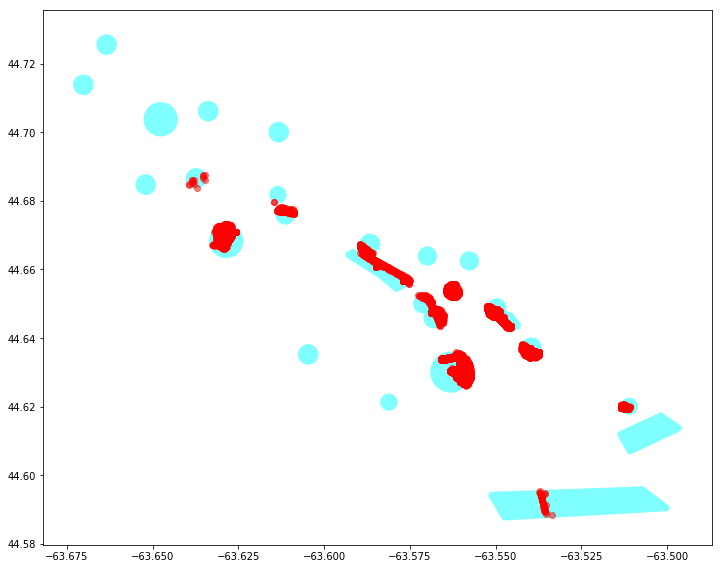

In [17]:
# Let's plot both port buffer and filtered data in one 
# plot to check intersections between message and port's buffer.
# https://stackoverflow.com/a/13873014/8243992
ax = gdf_ports.plot(color='cyan', figsize=(12,12), alpha=0.5)
gdf_AISData_filtered.plot(ax=ax, color='red', figsize=(12,12), alpha=0.5)

# Question 2

In [18]:
# The below function will count number of messages intersected per port.
# It will be useful to identify message density per port.
# https://stackoverflow.com/a/53551371/8243992
def countMessage(PortDataFrameWithVisit, PortDataFrame):
  del PortDataFrameWithVisit['combine']
  newDataFrame = PortDataFrame
  newDataFrame['messageCount'] = 0   # make new column and assign 0 to every rows initially
  index_count = 0
  for port in PortDataFrameWithVisit:
    count = PortDataFrameWithVisit[port].sum()   # Count number of True in a column
    newDataFrame['messageCount'][index_count] = count   # assign count
    index_count = index_count + 1
  return newDataFrame
df_ports_with_message_count = countMessage(gdf_AISData_portVisit, df_ports)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# Let's check the message density for each port
df_ports_with_message_count

,field_1,port_name,size,geometry,messageCount
0,0,pointpolygon,0.0000,"POLYGON ((-63.59160304069519 44.6649292254607,...",1094
1,1,port1,0.0018,"POLYGON ((-63.569431 44.649993, -63.5694396674...",80
2,2,port2,0.0018,"POLYGON ((-63.60949000000001 44.675853, -63.60...",229
3,3,ind,0.0000,POLYGON ((-63.54742169380188 44.64697911403847...,4504
4,4,port5,0.0018,"POLYGON ((-63.568048 44.663875, -63.5680566674...",0
5,5,port6,0.0018,"POLYGON ((-63.555828 44.662453, -63.5558366674...",0
6,6,port7,0.0018,"POLYGON ((-63.547843 44.648763, -63.5478516674...",704985
7,7,south_enterance,0.0000,POLYGON ((-63.50715637207031 44.59572358282151...,44
8,8,auto_port,0.0015,"POLYGON ((-63.50949499999999 44.62011, -63.509...",2215
9,9,southend container terminal,0.0050,"POLYGON ((-63.55805200000001 44.63004, -63.558...",8722


Text(0.5, 1.0, 'message density')

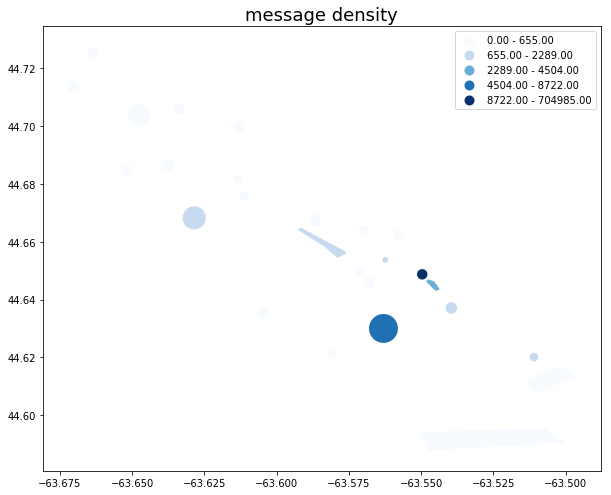

In [20]:
# Let's plot message density. Darker colors indicate high message density
# and lighter color indicates lower message density.
# http://geopandas.org/mapping.html#choropleth-maps
df_ports_with_message_count.plot(column='messageCount', cmap="Blues",legend=True, figsize=(10, 10),scheme="naturalbreaks")
plt.title("message density",fontsize=18)

# Question 3

In [0]:
# Let's read the AISData again. 
df_AISData_question3 = pd.read_csv('AISData.csv')
gdf_AISData_question3 = gpd.GeoDataFrame(df_AISData_question3.drop(['x', 'y'], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[shapely.geometry.Point(xy) for xy in zip(df_AISData_question3.x, df_AISData_question3.y)])  # to get exact location of vesells

In [0]:
# Now, in order to consider 1 hour time interval, we are fetching time from
# event_time column. We are extracting hour from event_time. 
# https://stackoverflow.com/a/25789512/8243992
gdf_AISData_question3['event_time'] = gdf_AISData_question3['event_time'].str[11:13]

In [23]:
# The updated data is as shown below. The event_time interval indicates
# hour for message.
gdf_AISData_question3.head()

,Unnamed: 0,event_time,position_accuracy,mmsi,sog,cog,geometry
0,0,09,0.0,316013808,3.0,319.500000,POINT (-63.55608167 44.624835)
1,1,09,0.0,316013808,3.0,320.700012,POINT (-63.55605333 44.62481667)
2,2,09,0.0,316013808,2.9,319.500000,POINT (-63.55613833 44.62486833)
3,3,09,0.0,316013808,3.0,319.799988,POINT (-63.55618667 44.62489833)
4,4,09,0.0,316013808,3.2,337.200012,POINT (-63.55599833 44.62488333)


In [0]:
# Now, let's make a list which contains data for all time intervals. 
# Each element in the list contains particular time interval data.
# For example, first element consists of time interval '00'. 
# https://stackoverflow.com/a/134951/8243992
dataframe_list_question3 = []
for i in range(24):
  dataframe_list_question3.append(gdf_AISData_question3[gdf_AISData_question3['event_time'] == "{:02d}".format(i)])

In [25]:
# Let's check data in the first element of list.
dataframe_list_question3[0].head()

,Unnamed: 0,event_time,position_accuracy,mmsi,sog,cog,geometry
533,533,00,0.0,316013808,8.5,168.699997,POINT (-63.551205 44.61994833)
534,534,00,0.0,316013808,8.5,168.699997,POINT (-63.551205 44.61994833)
541,541,00,0.0,316013808,8.3,168.500000,POINT (-63.55109667 44.61956833)
545,545,00,0.0,316013808,8.3,168.600006,POINT (-63.55101167 44.61923833)
546,546,00,0.0,316013808,8.3,168.600006,POINT (-63.55101167 44.61923833)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Computation for interval 1 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Computation for interval 2 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Computation for interval 3 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Computation for interval 4 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Computation for interval 5 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Computation for interval 6 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Computation for interval 7 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Computation for interval 8 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Computation for interval 9 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Computation for interval 10 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 11 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 12 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 13 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 14 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 15 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 16 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 17 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 18 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 19 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 20 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 21 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 22 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 23 completed.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computation for interval 24 completed.


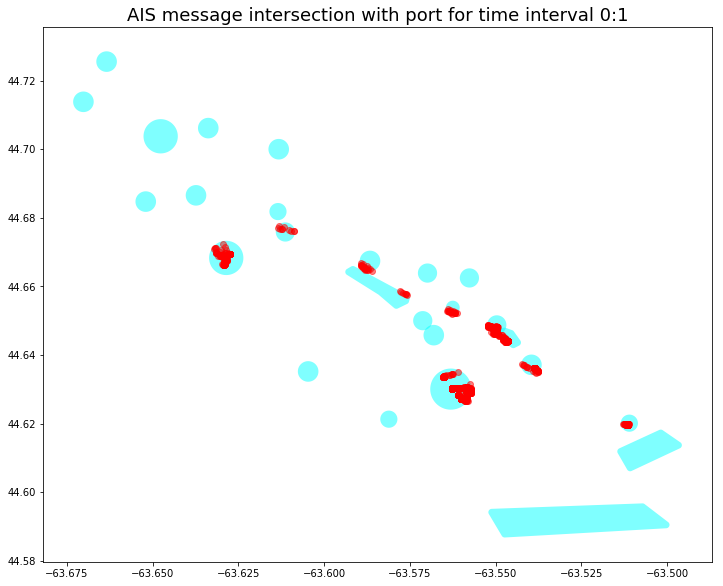

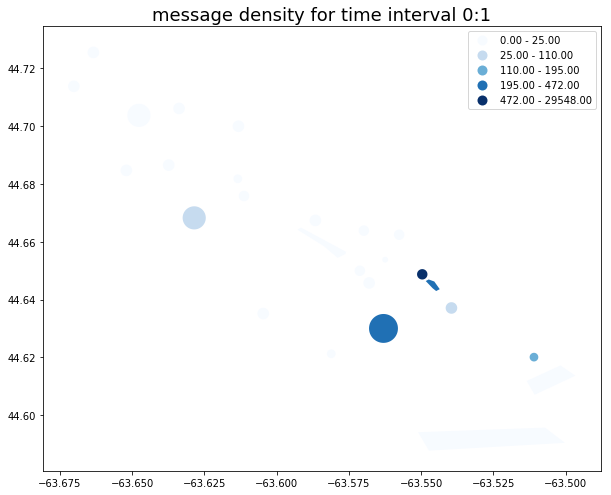

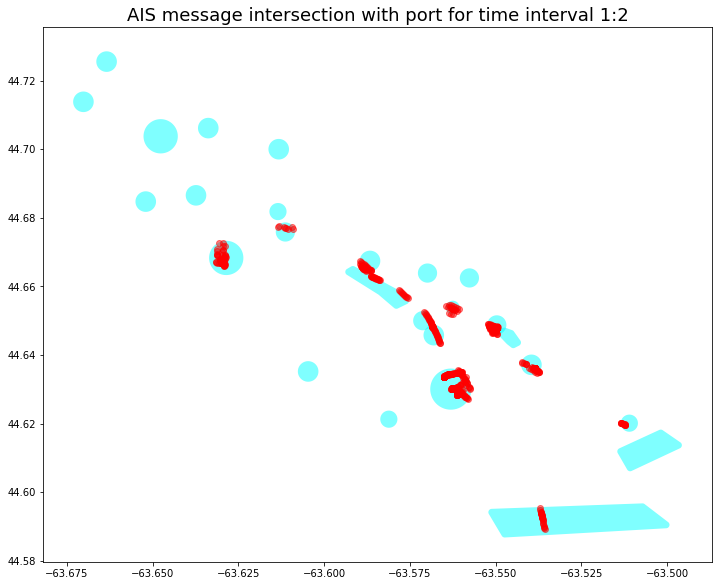

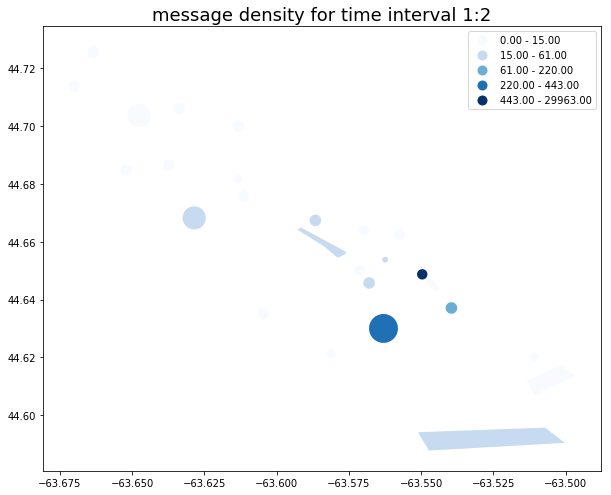

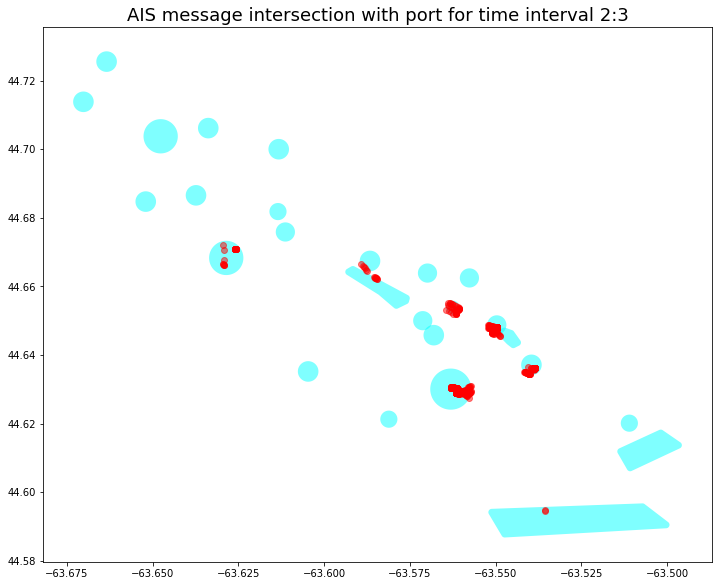

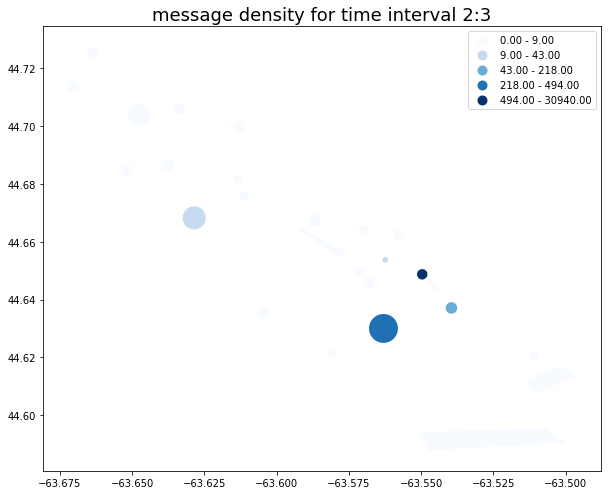

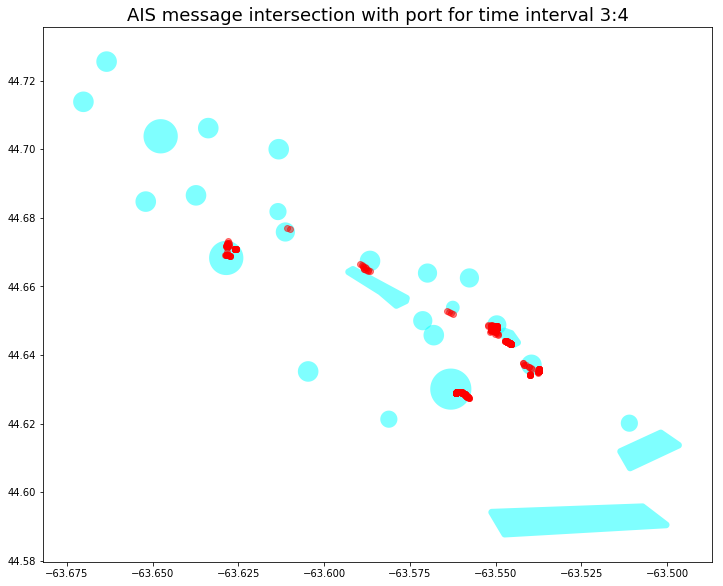

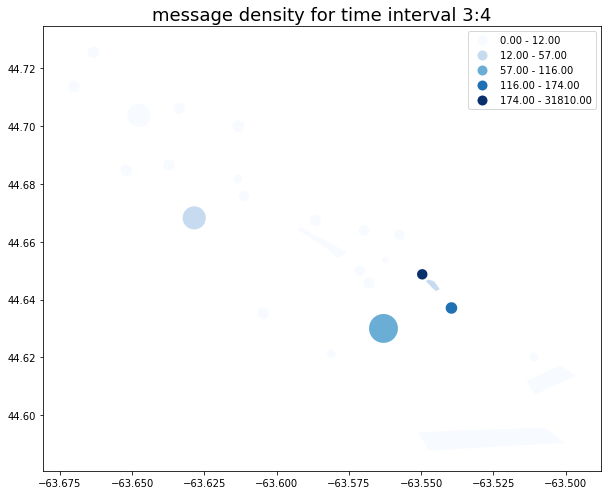

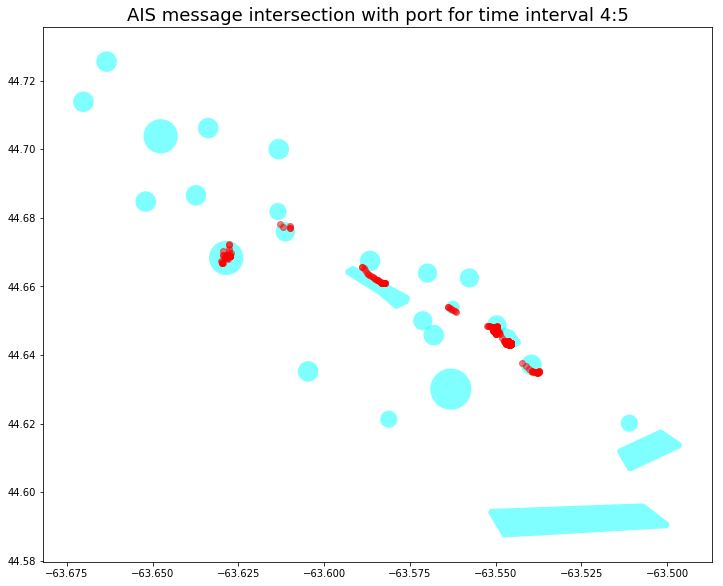

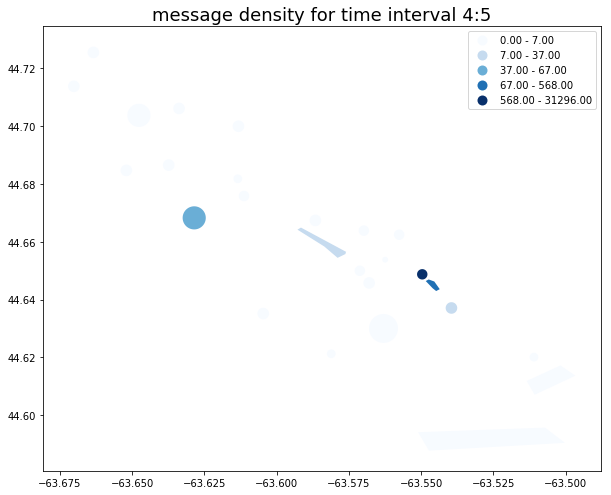

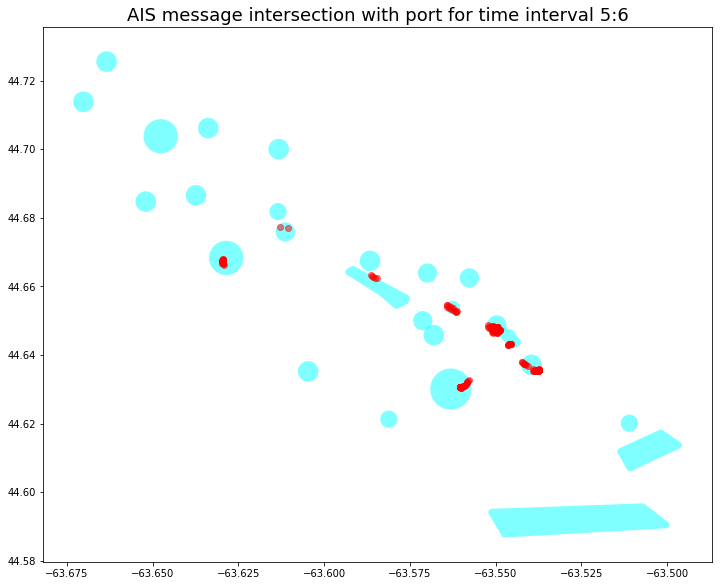

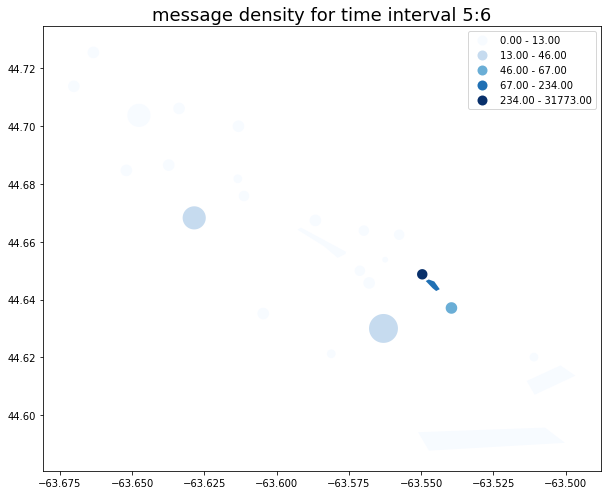

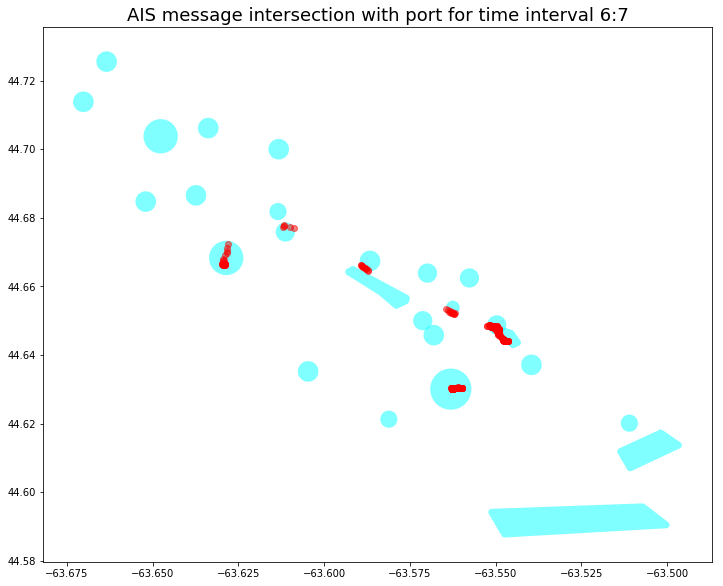

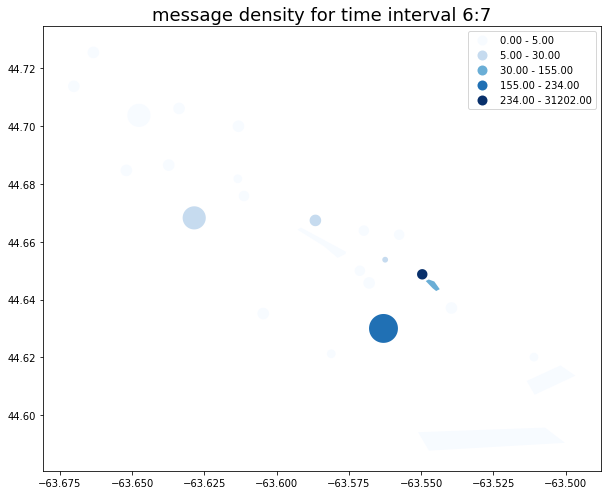

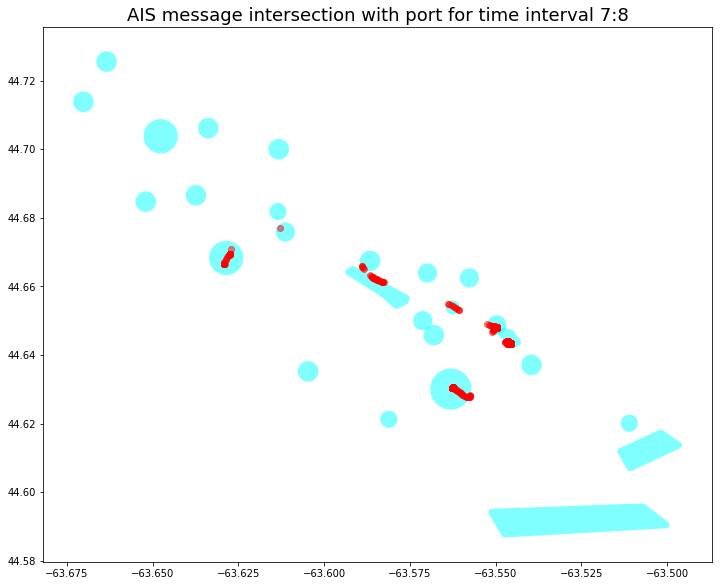

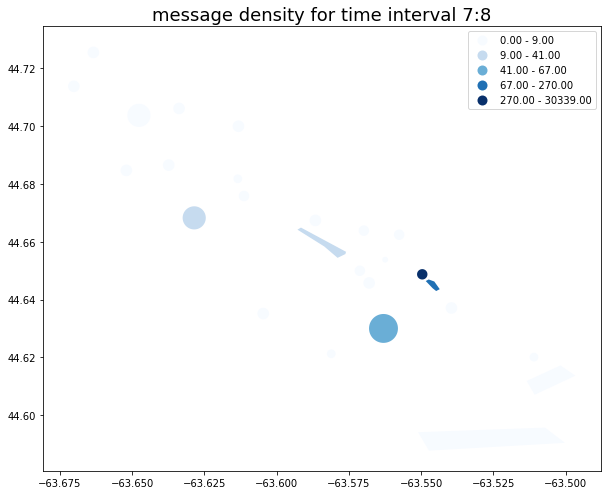

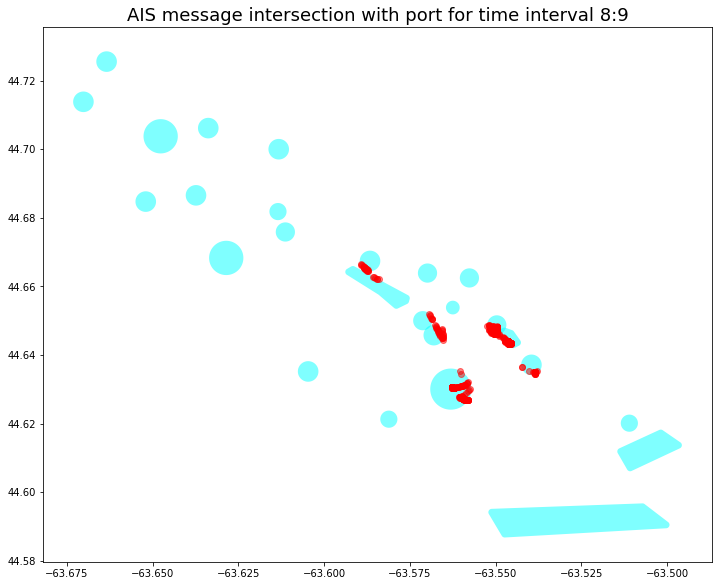

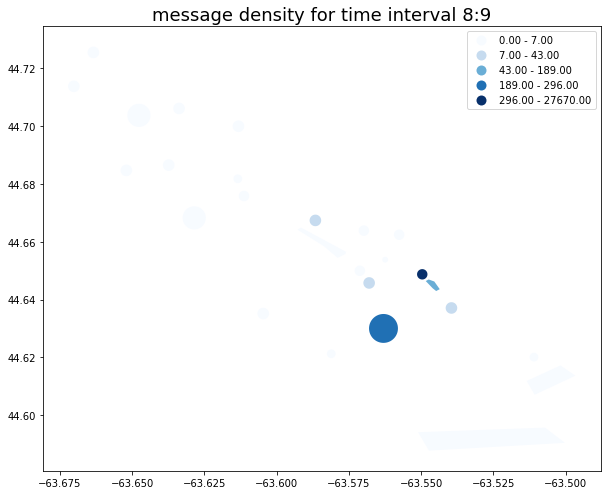

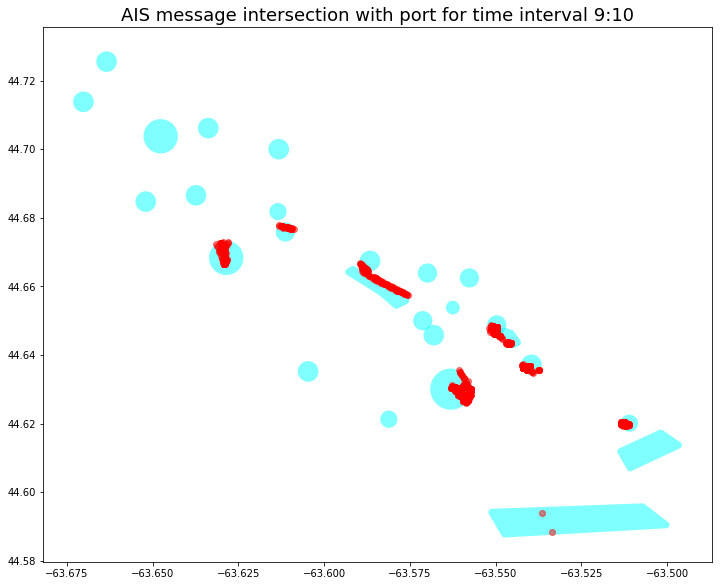

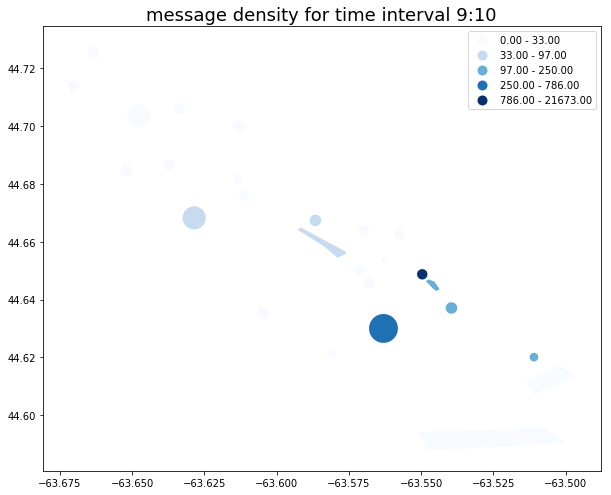

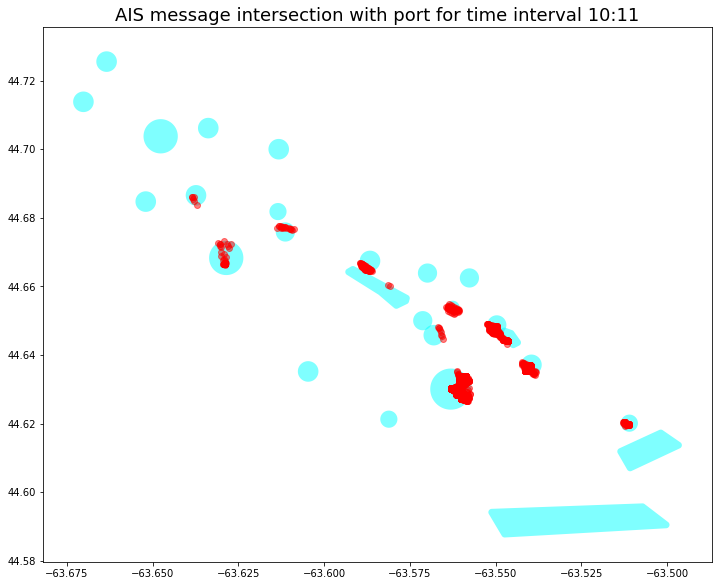

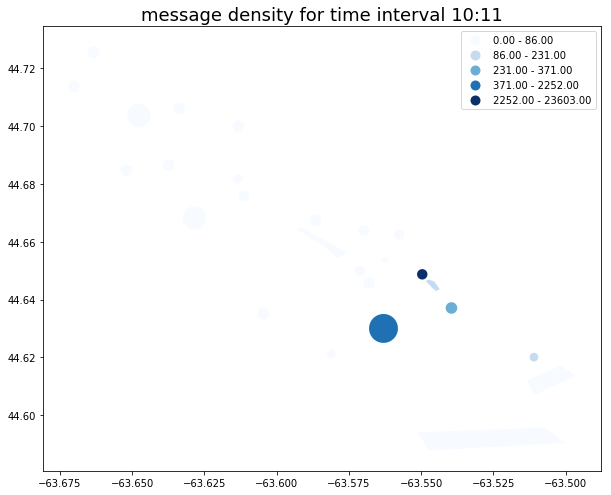

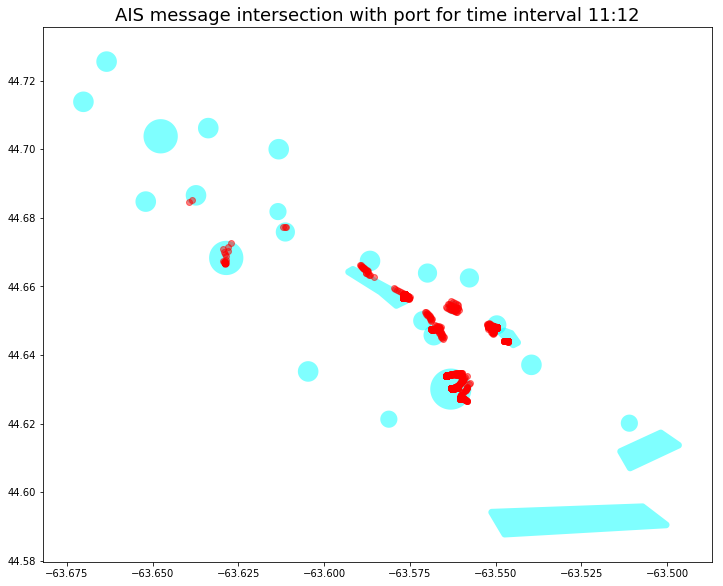

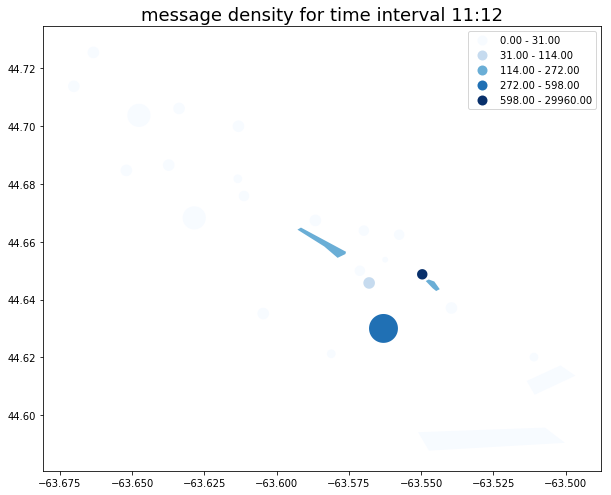

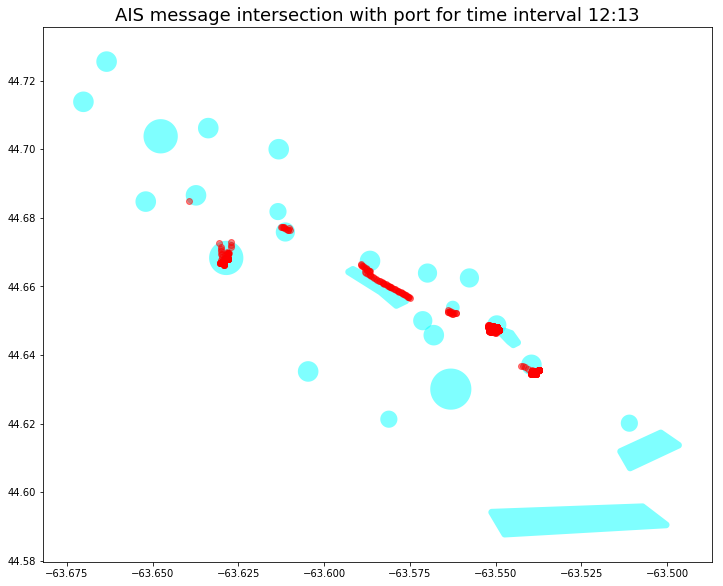

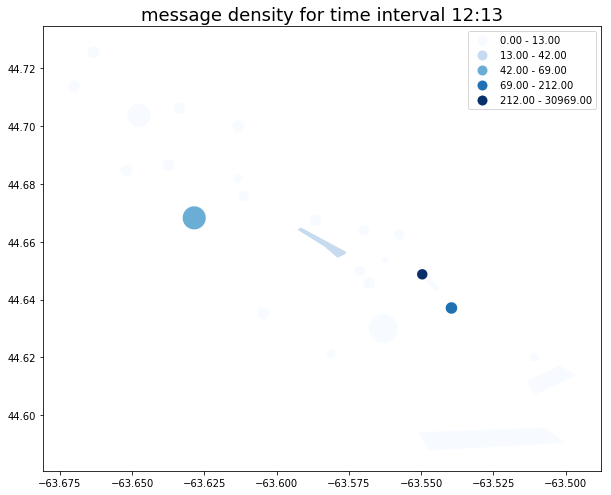

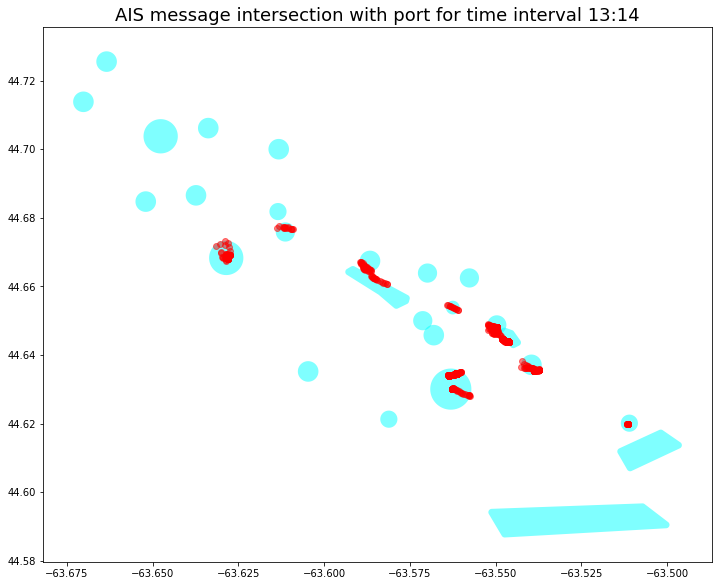

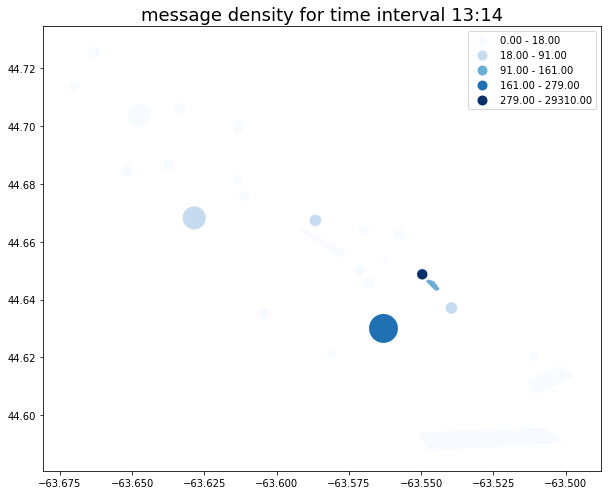

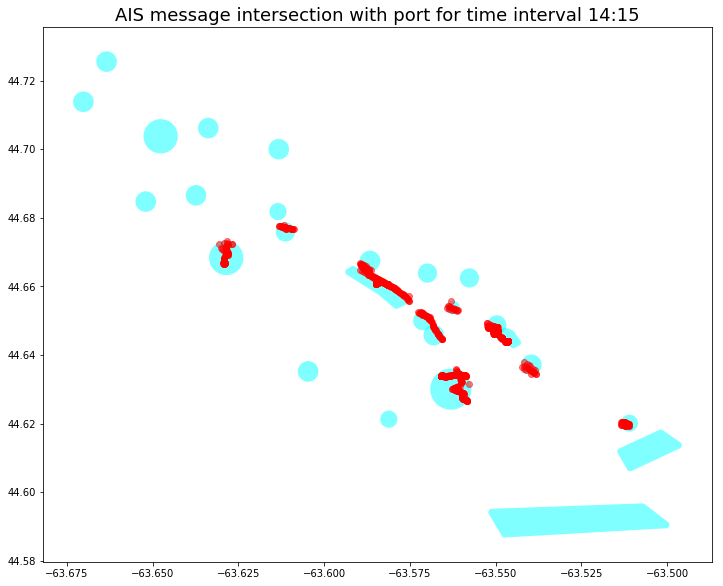

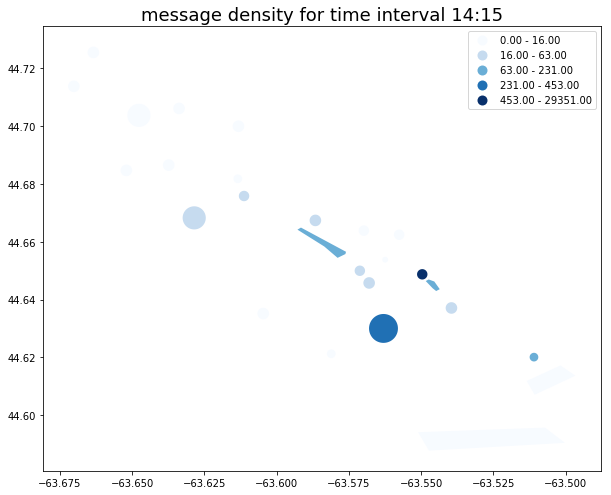

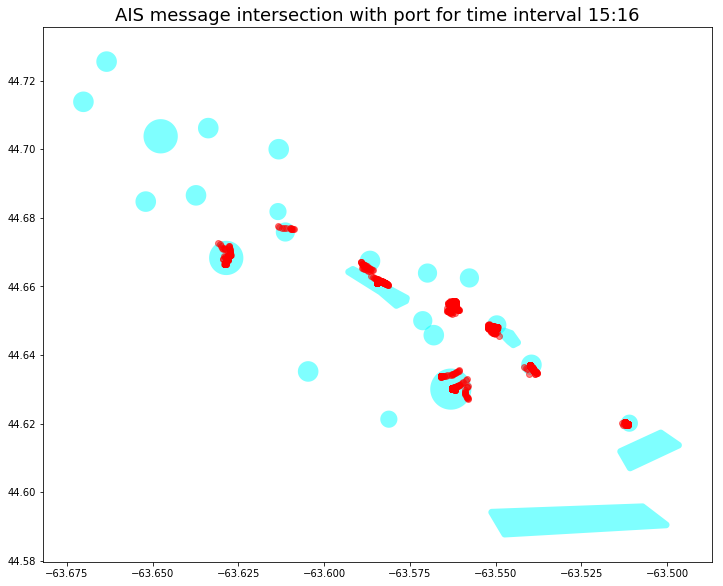

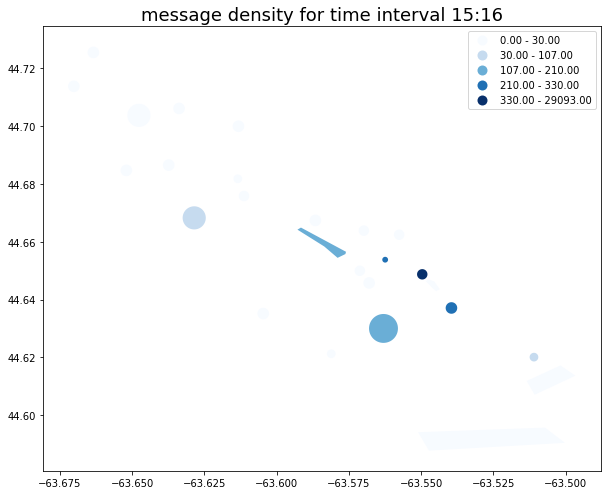

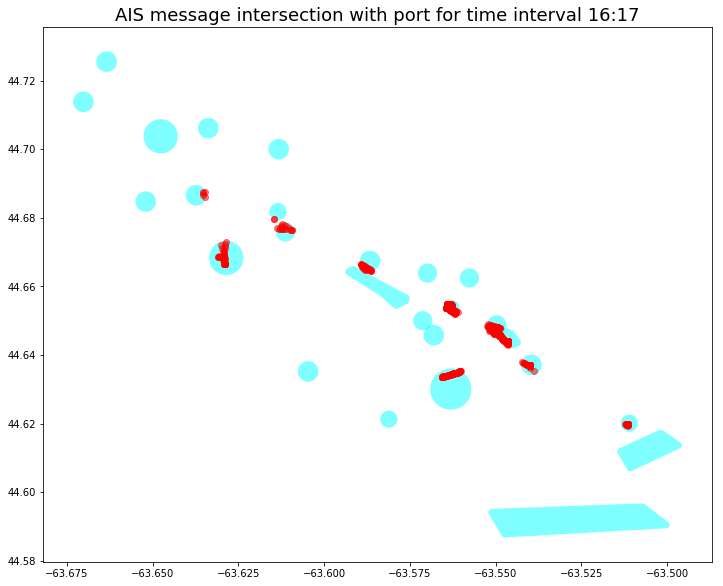

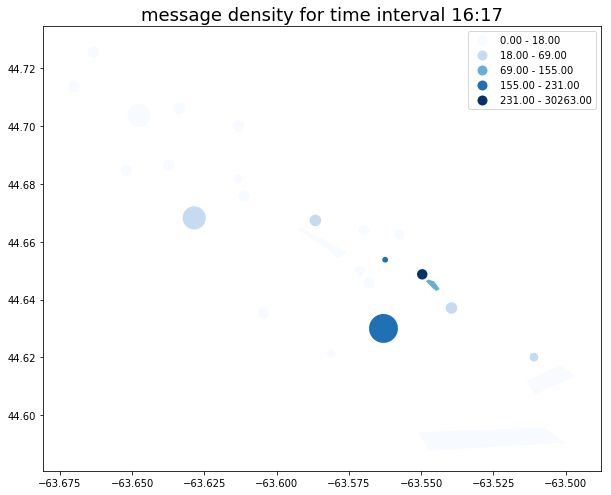

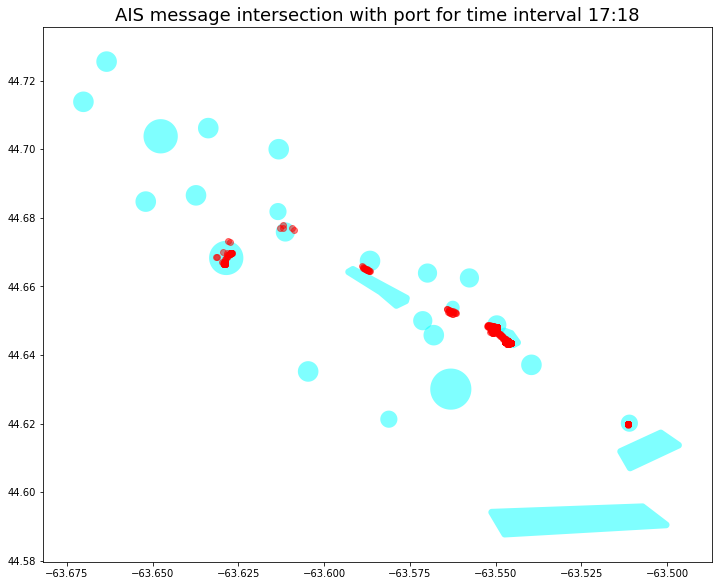

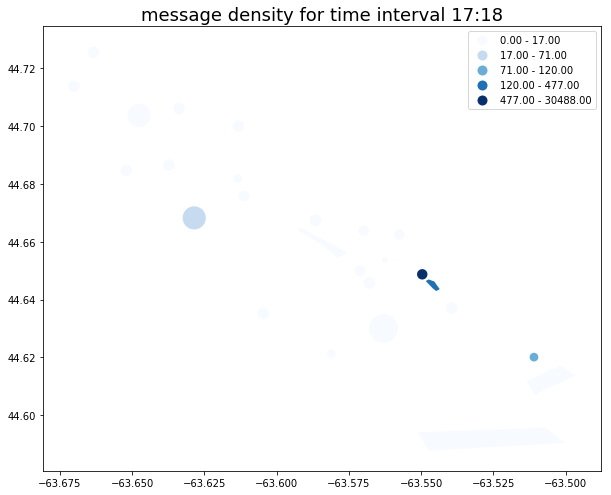

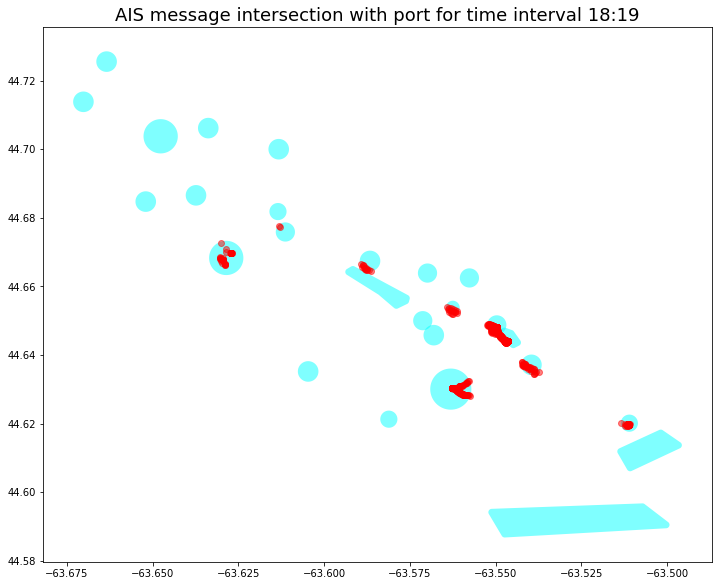

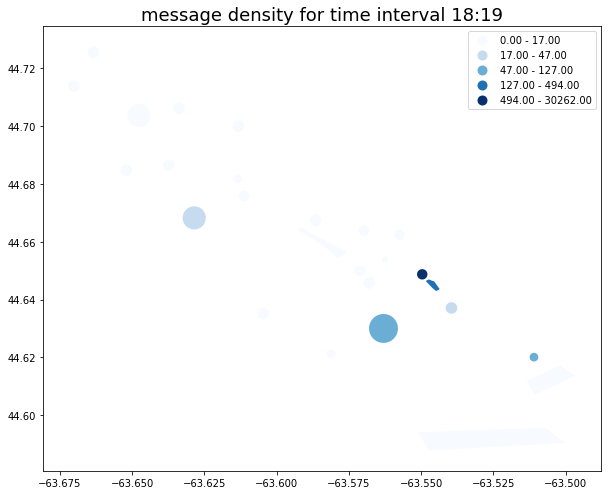

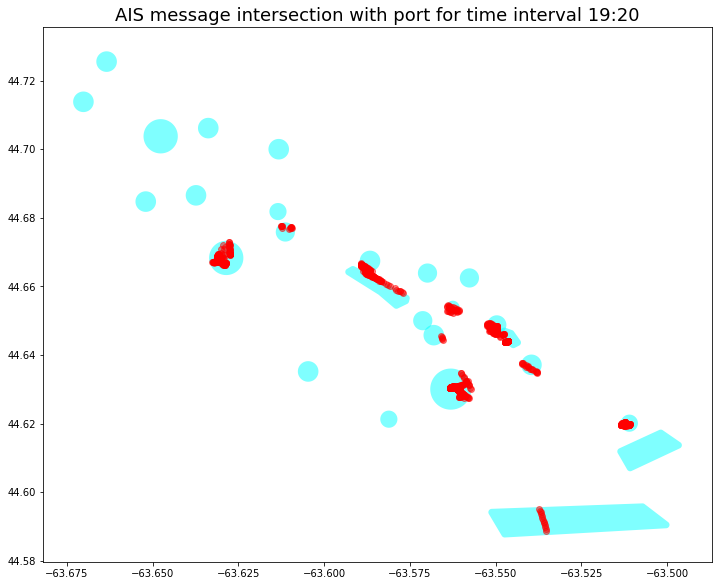

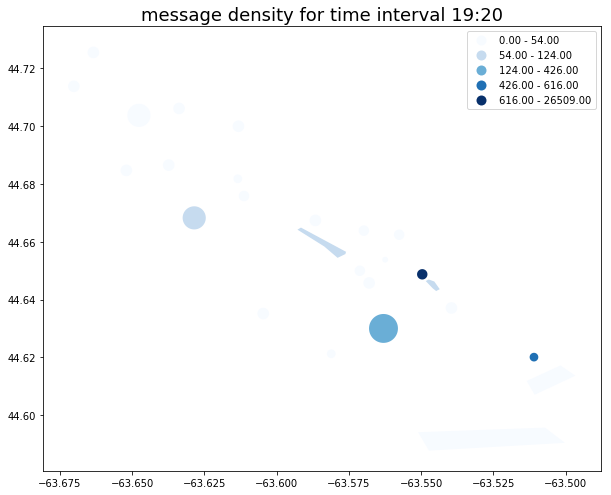

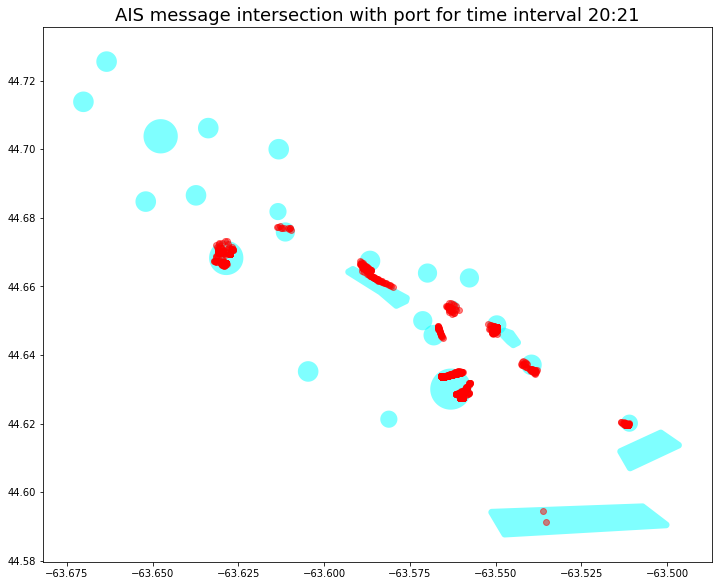

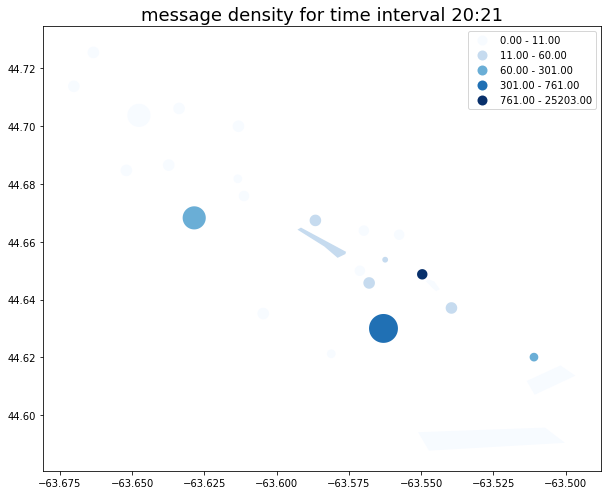

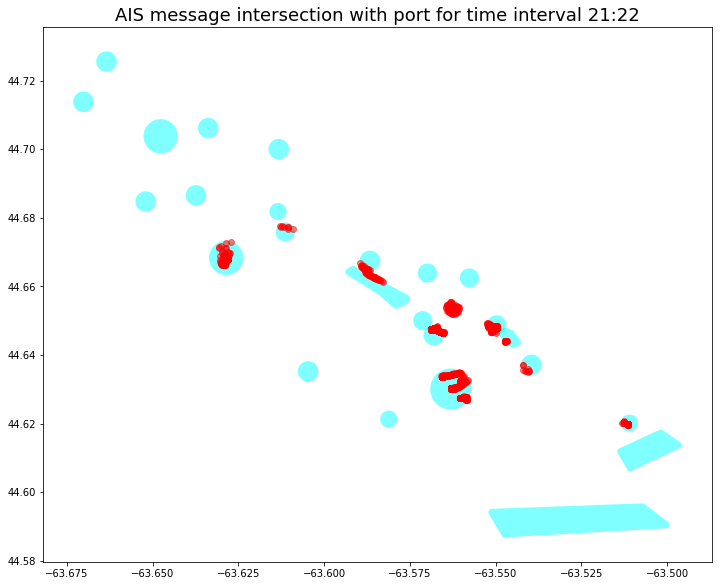

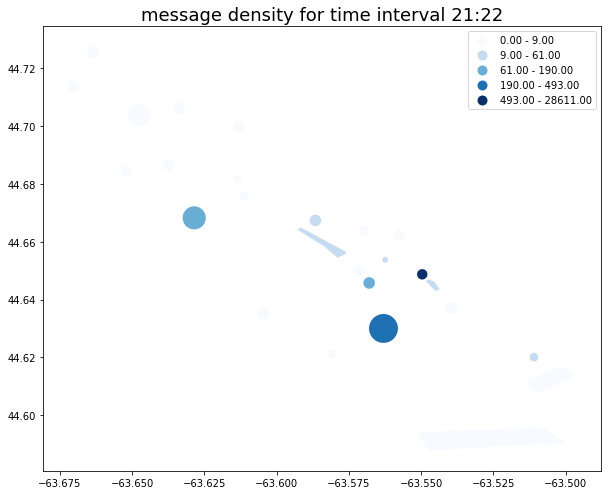

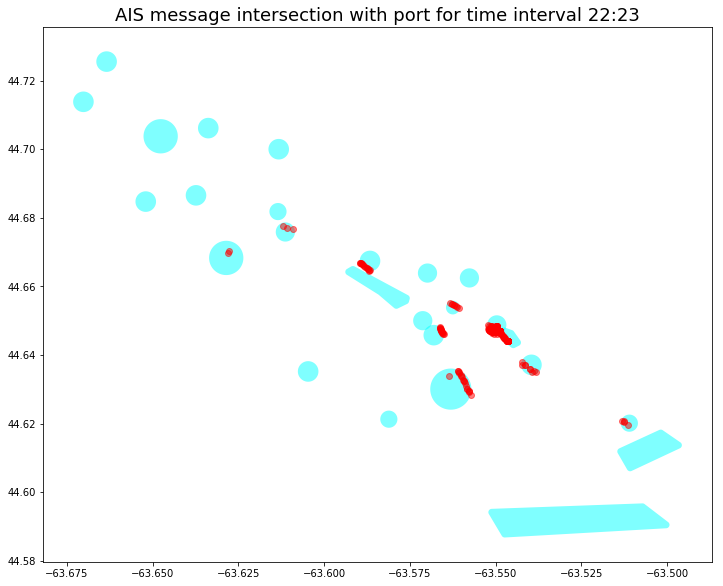

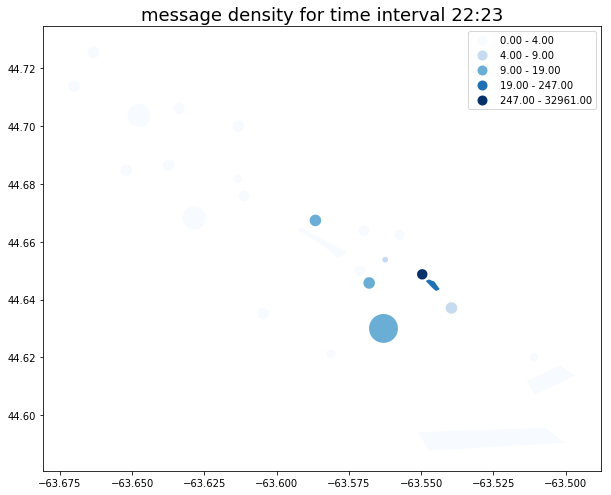

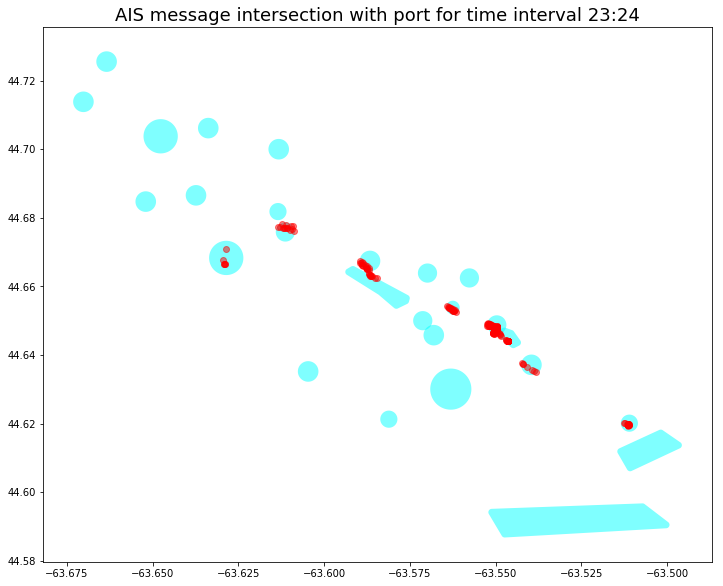

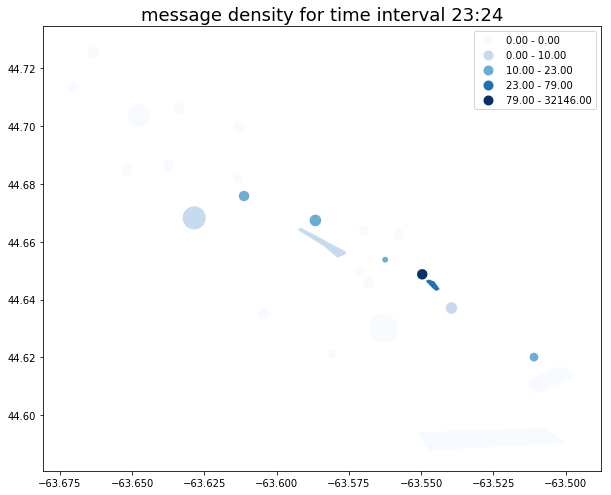

In [26]:
# The below loop will repeat question 1 and 2, and save the images in a folder.
# https://stackoverflow.com/a/18992172/8243992
count = 0
for dataframe in dataframe_list_question3:
  df_port_visit = checkPortVisit(dataframe)
  dataframe['intersectWithPort'] = df_port_visit['combine']
  dataframe_filtered = filterByVisit(dataframe, df_port_visit)
  ax = gdf_ports.plot(color='cyan', figsize=(12,12), alpha=0.5)
  fig_intersection = dataframe_filtered.plot(ax=ax, color='red', figsize=(12,12), alpha=0.5)
  plt.title("AIS message intersection with port for time interval "+str(count)+":"+str(count+1),fontsize=18)
  fig_intersection.figure.savefig('/content/IntersectionImage'+str(count)+'.jpg')
  ports_message_count = countMessage(df_port_visit, df_ports)
  message_plot = ports_message_count.plot(column='messageCount', cmap="Blues",legend=True, figsize=(10, 10),scheme="naturalbreaks")
  plt.title("message density for time interval "+str(count)+":"+str(count+1),fontsize=18)
  message_plot.figure.savefig('/content/MessageDensityCount'+str(count)+'.jpg')
  count = count + 1
  print("Computation for interval "+str(count)+" completed.")

# Question 4

In [0]:
# Let's read AISData
df_AISData_question4 = pd.read_csv('AISData.csv')
gdf_AISData_question4 = gpd.GeoDataFrame(df_AISData_question4.drop(['x', 'y'], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[shapely.geometry.Point(xy) for xy in zip(df_AISData_question4.x, df_AISData_question4.y)])  # to get exact location of vesells

In [28]:
# We are selecting 'port7' as it has highest message density. 
# Thus, it can be used to extract better insights.
# Below, we are appending a column which contains port7 message for each port.
# Tue value indicates that the message interects a port buffer and false indicates
# that the message is not intersecting with the port buffer.
gdf_AISData_question4['port7'] = gdf_AISData_portVisit['port7']
gdf_AISData_question4.head()

,Unnamed: 0,event_time,position_accuracy,mmsi,sog,cog,geometry,port7
0,0,2019-04-11T09:47:30.153Z,0.0,316013808,3.0,319.500000,POINT (-63.55608167 44.624835),False
1,1,2019-04-11T09:47:27.273Z,0.0,316013808,3.0,320.700012,POINT (-63.55605333 44.62481667),False
2,2,2019-04-11T09:47:34.340Z,0.0,316013808,2.9,319.500000,POINT (-63.55613833 44.62486833),False
3,3,2019-04-11T09:47:37.087Z,0.0,316013808,3.0,319.799988,POINT (-63.55618667 44.62489833),False
4,4,2019-04-19T09:52:19.358Z,0.0,316013808,3.2,337.200012,POINT (-63.55599833 44.62488333),False


In [0]:
# Now, let's keep only those message which intersects with port7 buffer.
# The True indicates intersection. Thus, we can keep those rows which has True 
# in port7 column.
gdf_AISData_port7visit = gdf_AISData_question4[gdf_AISData_question4['port7'] == True]

In [0]:
# Now, let's divide the data into time intervals.
# The logic of division is same as question 3.
gdf_AISData_question4['event_time'] = gdf_AISData_question4['event_time'].str[11:13]

In [0]:
# Now, let's check number of messages in each time interval.
# The value_count function returns series. We will convert it into dataframe.
save_series = gdf_AISData_question4['event_time'].value_counts()
gdf_AISData_time = pd.DataFrame({'time_interval': save_series.index, 'count': save_series.values})

In [32]:
# Some of the values in event_time column are random. Thus, we are removing those
# rows which has time_interval as blank.
gdf_AISData_time = gdf_AISData_time[gdf_AISData_time['time_interval'] != '']
gdf_AISData_time

,time_interval,count
0,22,34368
1,14,33250
2,02,33209
3,23,33105
4,13,33073
5,12,32808
6,03,32699
7,11,32681
8,04,32541
9,18,32393


In [0]:
# Let's sort the data based on time interval.
gdf_AISData_time.sort_values(['time_interval'], inplace=True)

In [34]:
# Let's check the data
gdf_AISData_time

,time_interval,count
14,00,31877
10,01,32321
2,02,33209
6,03,32699
8,04,32541
11,05,32312
15,06,31873
19,07,31246
17,08,31729
23,09,27980


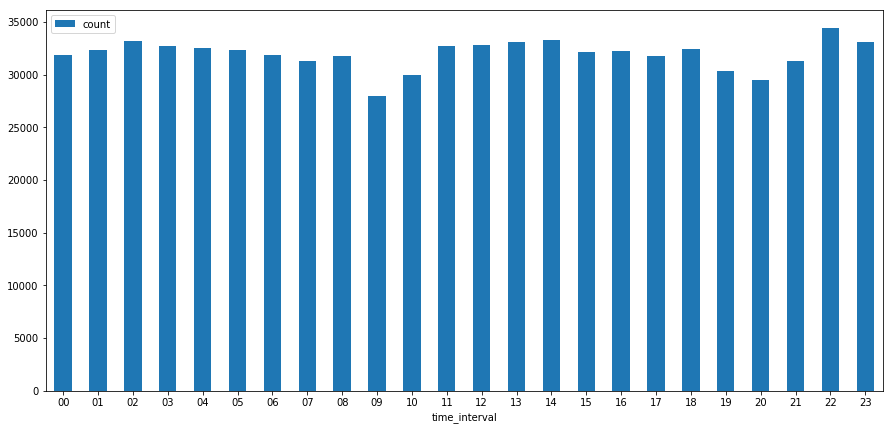

In [35]:
# Let's plot the data in bar graph.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = gdf_AISData_time.plot.bar(x='time_interval', y='count', rot=0, figsize=(15,7))

Text(0.5, 0, 'Time interval')

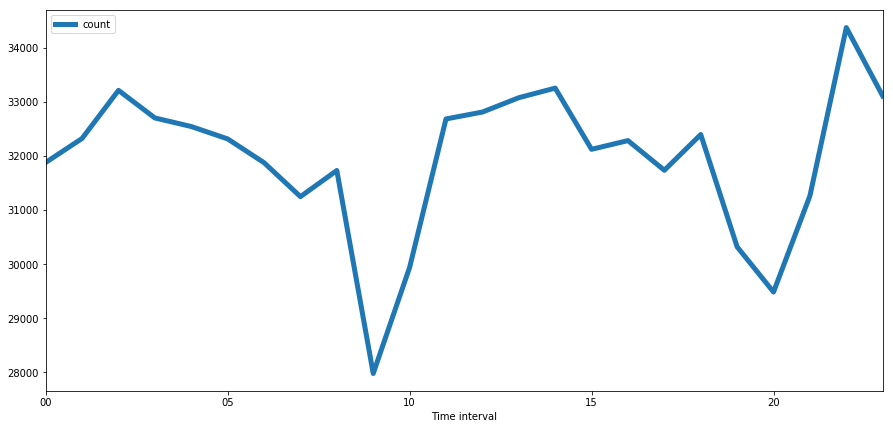

In [36]:
# Let's plot the data into graph.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
gdf_AISData_time.set_index('time_interval', inplace=True)
gdf_AISData_time.plot(figsize=(15,7), linewidth=5)
plt.xlabel('Time interval')

# Question 6

In [0]:
# Import AISData which contains vessels data
df_AISData_question6 = pd.read_csv('AISData.csv')
gdf_AISData_question6 = gpd.GeoDataFrame(df_AISData_question6.drop(['x', 'y'], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[shapely.geometry.Point(xy) for xy in zip(df_AISData_question6.x, df_AISData_question6.y)])  # to get exact location of vesells

In [0]:
# Let's create buffer for ports. 
# The buffer is kept for 1 km. If we increase it, there are high chances that the ports will overlap.
# https://gis.stackexchange.com/a/253387
df_ports_question6 = gpd.read_file("assignment3shapefile.shp")
gdf_ports_question6 = df_ports_question6.geometry.buffer(0.001)

In [0]:
# Check which message intersects with which port. The checkPortVisit is written in Question 1.
gdf_AISData_portVisit_question6 = checkPortVisit(gdf_AISData_question6)

In [0]:
# Add intersectWithPort column to data to keep track of a message intersecting with ports.
df_AISData_question6['intersectWithPort'] = gdf_AISData_portVisit_question6['combine']

In [0]:
# Keep only those messages which intersects with AT LEAST one port. 
# We are considering outliers to those messages which do not intersect with any ports.
gdf_AISData_filtered_question6 = filterByVisit(df_AISData_question6, gdf_AISData_portVisit_question6)

In [42]:
# We were facing memory issues for DBScan on whole dataframe. Thus, we are 
# performing DBScan on breaked data among time interval. 
# However, we can perform DBScan on whole dataframe if a computing machine with higher memory power
# is allocated. In order to make such changes, just whole dataframe needs to be passed in DBScan 
# instead of just one time interval.
# Let's break data into time intervals. This step is similar to Question 3.
gdf_AISData_filtered_question6['event_time'] = gdf_AISData_filtered_question6['event_time'].str[11:13]
dataframe_list_question6 = []
for i in range(24):
  dataframe_list_question6.append(gdf_AISData_filtered_question6[gdf_AISData_filtered_question6['event_time'] == "{:02d}".format(i)])
dataframe_list_question6[0].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,event_time,x,y,position_accuracy,mmsi,sog,cog,intersectWithPort
3224,3224,00,-63.512777,44.619988,NaN,316013808,NaN,NaN,"[False, False, False, False, False, False, Fal..."
3229,3229,00,-63.512563,44.619937,NaN,316013808,NaN,NaN,"[False, False, False, False, False, False, Fal..."
3230,3230,00,-63.512485,44.619925,NaN,316013808,NaN,NaN,"[False, False, False, False, False, False, Fal..."
3260,3260,00,-63.512113,44.619685,NaN,316013808,NaN,NaN,"[False, False, False, False, False, False, Fal..."
3265,3265,00,-63.512177,44.619897,NaN,316013808,NaN,NaN,"[False, False, False, False, False, False, Fal..."


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


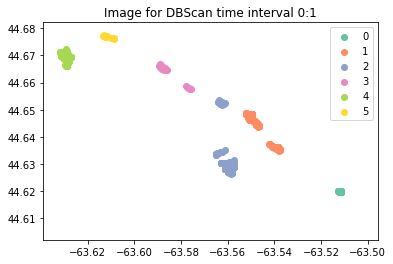

Computation for time interval 0 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


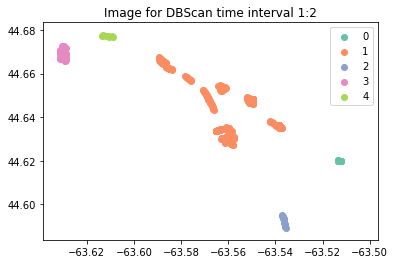

Computation for time interval 1 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


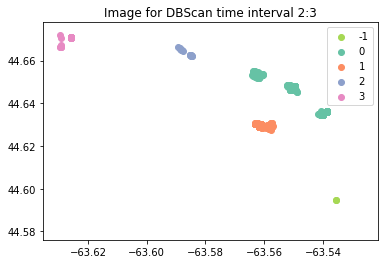

Computation for time interval 2 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


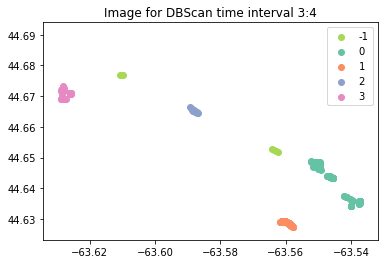

Computation for time interval 3 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


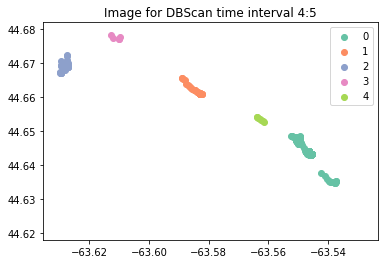

Computation for time interval 4 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


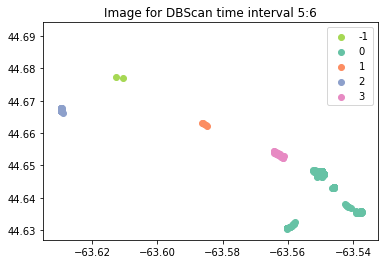

Computation for time interval 5 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


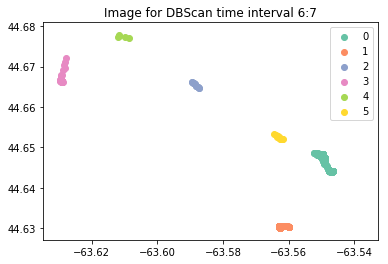

Computation for time interval 6 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


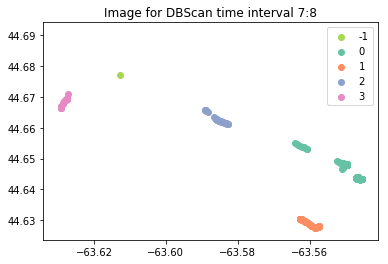

Computation for time interval 7 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


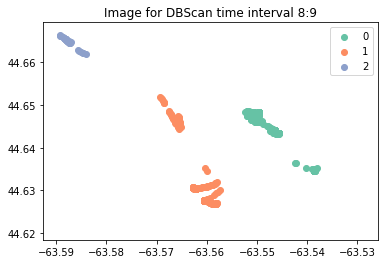

Computation for time interval 8 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


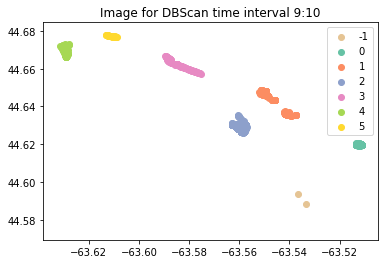

Computation for time interval 9 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


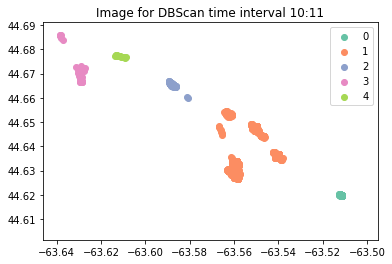

Computation for time interval 10 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


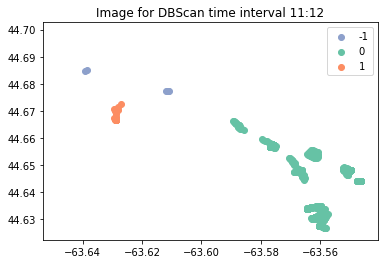

Computation for time interval 11 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


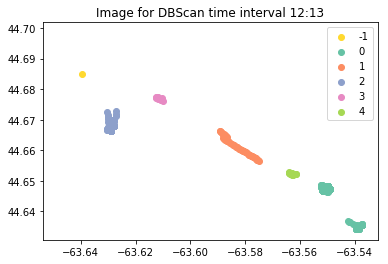

Computation for time interval 12 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


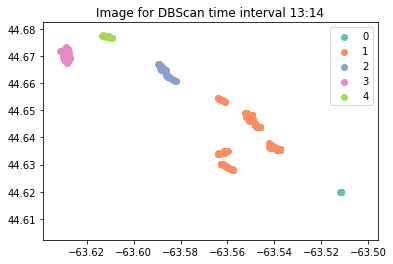

Computation for time interval 13 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


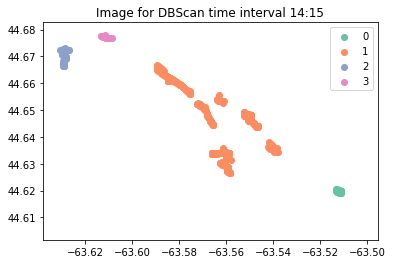

Computation for time interval 14 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


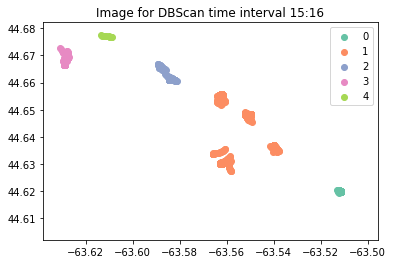

Computation for time interval 15 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


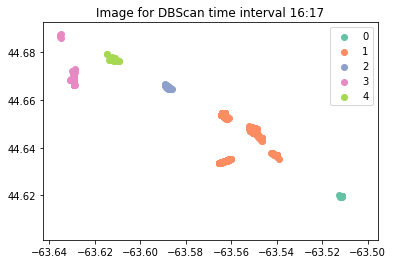

Computation for time interval 16 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


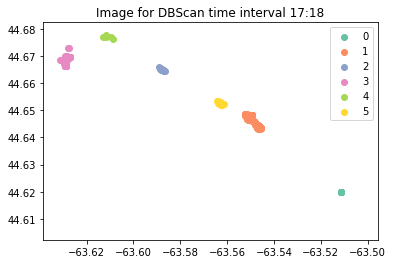

Computation for time interval 17 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


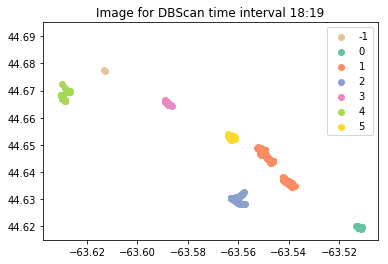

Computation for time interval 18 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


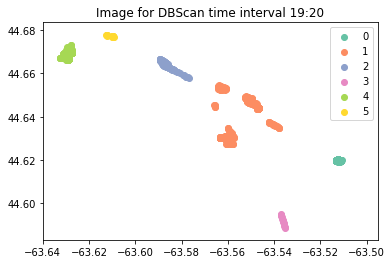

Computation for time interval 19 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


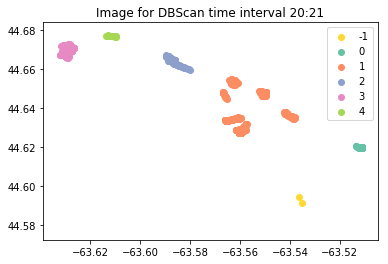

Computation for time interval 20 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


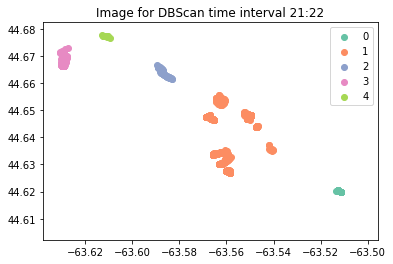

Computation for time interval 21 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


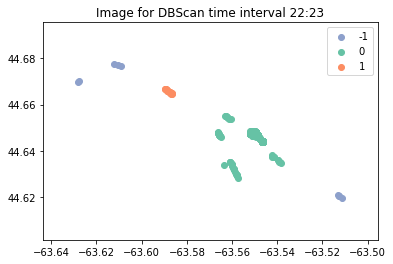

Computation for time interval 22 complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


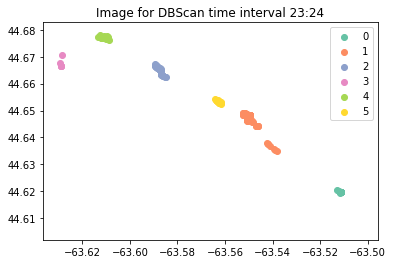

Computation for time interval 23 complete


In [43]:
# Let's make coordinates by using x and y coordinate of dataframe.
# We are using below link as reference which contains DBScan implementation with map related data.
# http://qingkaikong.blogspot.com/2016/08/clustering-with-dbscan.html
# https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib
count = 0
for dataframe in dataframe_list_question6:
  coords = dataframe.as_matrix(columns=['x', 'y'])  # select coordinates
  kms_per_radian = 6371.0088
  epsilon = 1 / kms_per_radian
  db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))  # pass radians
  cluster_labels = db.labels_  # cluster labels
  n_clusters = len(set(cluster_labels))   # determine number of clusters
  clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, n_clusters)])  # Assign number to clusters
  dataframe['labels'] = db.labels_  # Assign labels to passed dataframe to keep track of which message to which cluster
  color_labels = set(cluster_labels)
  rgb_values = sns.color_palette("Set2", len(clusters))
  color_map = dict(zip(color_labels, rgb_values))  # Assign unique RGB color to clusters to show in plots
  grouped = dataframe.groupby(dataframe['labels'])   # Group by cluster labels
  for key, group in grouped:
    plt.scatter(x=group.x, y=group.y, label=key, color=color_map[key])
  plt.title("Image for DBScan time interval "+str(count)+":"+str(count+1))
  plt.legend()
  plt.savefig('/content/DBScan'+str(count)+'.jpg')  # Save figure
  plt.show()  # Show figure
  print("Computation for time interval "+str(count)+" complete")
  count = count+1